# Making Networks Compete

## Achieving more realistic results

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def normalize(X):
    X = X.reshape(len(X), 784)
    X = X.astype('float32')/255
    return X

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = normalize(X_train)

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
input_dim = 100
np.random.seed(42)
optimizer = Adam(lr=0.0002, beta_1=0.5)

gen = Sequential()
gen.add(Dense(256, input_dim=input_dim))
gen.add(LeakyReLU(alpha=0.2))
gen.add(BatchNormalization())
gen.add(Dense(512))
gen.add(LeakyReLU(alpha=0.2))
gen.add(BatchNormalization())
gen.add(Dense(1024))
gen.add(LeakyReLU(alpha=0.2))
gen.add(BatchNormalization())
gen.add(Dense(784, activation='sigmoid'))
gen.compile(loss='binary_crossentropy', 
            optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [4]:
dsc = Sequential()
dsc.add(Dense(1024, input_dim=784))
dsc.add(LeakyReLU(alpha=0.2))
dsc.add(Dropout(0.3))
dsc.add(Dense(512))
dsc.add(LeakyReLU(alpha=0.2))
dsc.add(Dropout(0.3))
dsc.add(Dense(256))
dsc.add(LeakyReLU(alpha=0.2))
dsc.add(Dropout(0.3))
dsc.add(Dense(1, activation='sigmoid'))  
dsc.compile(loss='binary_crossentropy', 
            optimizer=optimizer)

In [5]:
def make_trainable(dnn, flag):
    dnn.trainable = flag
    for l in dnn.layers:
        l.trainable = flag
        
make_trainable(dsc, False)
inputs = Input(shape=(input_dim, ))
hidden = gen(inputs)
output = dsc(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy',
            optimizer=optimizer)

In [6]:
def create_noise(n, z):
    return np.random.normal(0, 1, size=(n, z))

def plot_sample(n, z):
    samples = gen.predict(create_noise(n, z))
    plt.figure(figsize=(15,3))
    for i in range(n):
        plt.subplot(1, n, (i+1))
        plt.imshow(samples[i].reshape(28, 28), 
                   cmap='gray_r')
        plt.axis('off')
    plt.show()  

Epoch 0


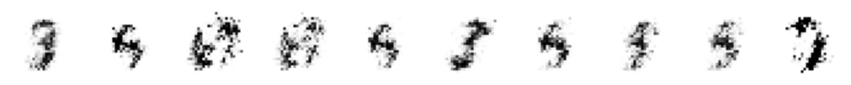

Epoch 10


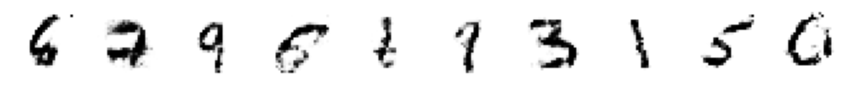

Epoch 20


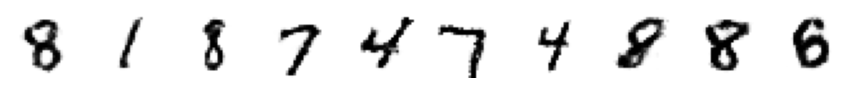

Epoch 30


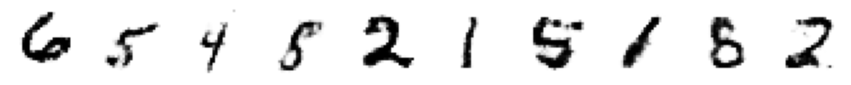

Epoch 40


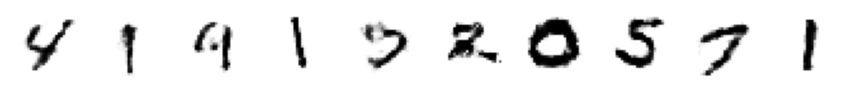

Epoch 50


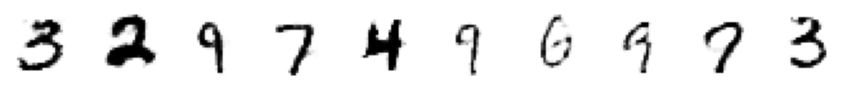

Epoch 60


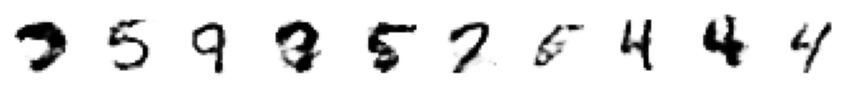

Epoch 70


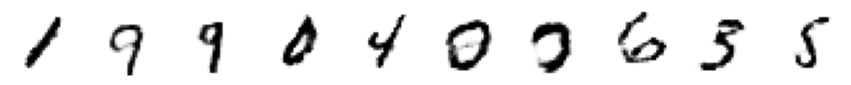

Epoch 80


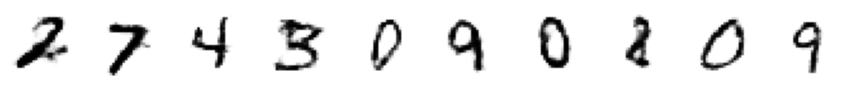

Epoch 90


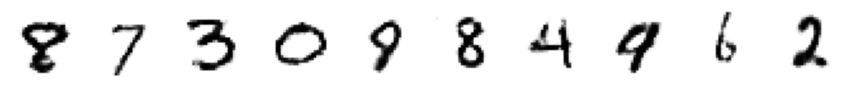

In [7]:
epochs = 100
batch_size = 128
batch_no = int(len(X_train) / batch_size)
gen_errors, dsc_errors = (list(), list())

for i in range(0, epochs):
    for j in range(batch_no): 
      
        # Drawing a random sample of the training set
        rand_sample = np.random.randint(0, len(X_train), size=batch_size)
        image_batch = X_train[rand_sample]
        
        # Creating noisy inputs for the generator
        input_noise = create_noise(batch_size, input_dim)

        # Generating fake images from the noisy input
        generated_images = gen.predict(input_noise)
        X = np.concatenate((image_batch, generated_images))
        
        # Creating somehow noisy labels
        y = np.concatenate([[0.9]*batch_size, [0.0]*batch_size])

        # Training discriminator to distinguish fakes from real ones
        make_trainable(dsc, True)
        dsc_loss = dsc.train_on_batch(X, y)
        make_trainable(dsc, False)

        # Trainining generating fakes
        input_noise = create_noise(batch_size, input_dim)
        fakes = np.ones(batch_size)
        for _ in range(4):
          gen_loss = gan.train_on_batch(input_noise, fakes)

    # Recording the losses
    gen_errors.append(gen_loss)
    dsc_errors.append(dsc_loss)

    # Showing intermediate results
    if i % 10 == 0:
      print("Epoch %i" % i)
      plot_sample(10, input_dim)

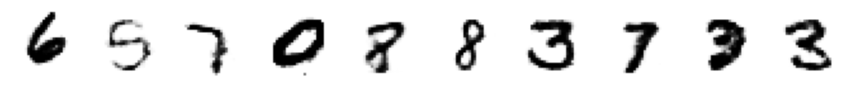

In [8]:
# Plotting the final result
plot_sample(10, input_dim)

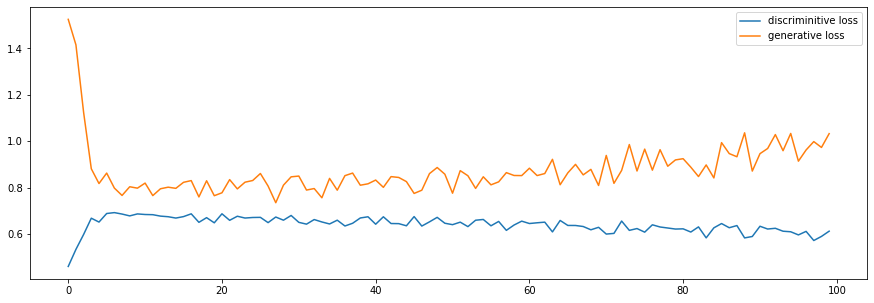

In [9]:
# Plotting the errors
plt.figure(figsize=(15, 5))
plt.plot(dsc_errors, label='discriminitive loss')
plt.plot(gen_errors, label='generative loss')
plt.legend()
plt.show()